In [1]:
#import tensorflow, keras and numpy

import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

## Creating the dataset

### The first step is to create a list of all the image paths using the glob module.

In [2]:
paths_path = "../../../keele_code/msc_project/Filestructure/Notebooks/imgs/lfw/*/*"
paths_list = glob.glob(paths_path)
paths_list[:1]

['../../../keele_code/msc_project/Filestructure/Notebooks/imgs/lfw/German_Khan/German_Khan_0001.jpg']

### We then create a list of labels with that paths_list

In [3]:
#for MAC
labels = [p.split("/")[-1].split("00")[0].replace("_", " ").rstrip() for p in paths_list]
labels[:5]

['German Khan',
 'Stefano Gabbana',
 'Dragan Covic',
 'Jeff Hornacek',
 'Sureyya Ayhan']

In [4]:
#labels = [p.split("\\")[-1].split("00")[0].replace("_", " ").rstrip() for p in paths_list]
#labels[:5]

In [5]:
len(labels)

13233

While there are a lot of images, many faces only have one example. This will make classification difficult. Let's find out how instances there are of individuals and select just the top 10.

In [6]:
face_labels = pd.Series(labels)
top_faces = face_labels.value_counts()[:10]
top_face_names = top_faces.index
top_face_names

Index(['Tony Blair', 'Donald Rumsfeld', 'Gerhard Schroeder', 'Colin Powell',
       'George W Bush', 'Ariel Sharon', 'Hugo Chavez', 'Junichiro Koizumi',
       'Jean Chretien', 'John Ashcroft'],
      dtype='object')

In [7]:
face_labels.index

RangeIndex(start=0, stop=13233, step=1)

We then transform the list into a dataframe, and reset_index() to create a simple lookup table with which to create numerical labels. We'll need them for the machine learning bit of the task.

In [8]:
face_lookup = pd.Series(top_face_names)
face_lookup = face_lookup.reset_index()
face_lookup.columns = ['num_label', 'name']
face_lookup.head()

,num_label,name
0,0,Tony Blair
1,1,Donald Rumsfeld
2,2,Gerhard Schroeder
3,3,Colin Powell
4,4,George W Bush


Now add that to face_labels so we have a numeric label. First we have to convert the face_labels to a DataFrame

In [9]:
fac_labels = face_labels.reset_index()
fac_labels.columns = ['idx', 'name']
fac_labels.head()

,idx,name
0,0,German Khan
1,1,Stefano Gabbana
2,2,Dragan Covic
3,3,Jeff Hornacek
4,4,Sureyya Ayhan


In [10]:
mgd = pd.merge(fac_labels, face_lookup, how="inner", left_on='name', right_on="name")
mgd.head()

,idx,name,num_label
0,2810,Gerhard Schroeder,2
1,2811,Gerhard Schroeder,2
2,2812,Gerhard Schroeder,2
3,2813,Gerhard Schroeder,2
4,2814,Gerhard Schroeder,2


In [11]:
mgd.shape

(811, 3)

### Create test/train split

So far we have a list of image data and a dataframe containing label data. The next step is to seperate our data into training and test data.

In [12]:
df = mgd.set_index("idx")
df = mgd['name']
y = mgd['num_label'] 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, 
                                                    random_state=42)

We can use the index of both test and train to create numpy arrays for Keras to handle.

In [13]:
img_train = [imread(img) for i, img in enumerate(paths_list) if i in X_train.index]
img_test = [imread(img) for i, img in enumerate(paths_list) if i in X_test.index]


### Now some final pre-preprocessing

/Users/davidelks/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


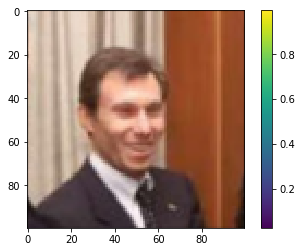

In [14]:
def resize_image(img):
    img = resize(img, (100, 100), anti_aliasing=True)
    return img

def rescale_image(img):
    return img /255

#First resize...
img_train = [resize_image(i) for i in img_train]
img_test = [resize_image(i) for i in img_test]

#...then output a sample to check it has worked...
io = resize_image(img_train[0])
plt.figure()
plt.imshow(io)
plt.colorbar()
plt.grid(False)
plt.show()

In [15]:
#And then rescale the RGB values to between 0 and 1 before we feed into the neural network
img_train = [rescale_image(i) for i in img_train]
img_test = [rescale_image(i) for i in img_test]

### Finally, we convert the lists into numpy arrays to feed into the neural network...

In [16]:
img_train_np = np.array(img_train)
img_test_np = np.array(img_test)

In [17]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [18]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

We fit the model and save the history of training in history so we can plot the loss curve

In [34]:
history = model.fit(img_train_np, y_train.values, epochs=200,
             validation_data=(img_test_np, y_test.values))

Train on 648 samples, validate on 163 samples
Epoch 1/200
648/648 [==============================] - 1s 2ms/step - loss: 0.5109 - acc: 0.9460 - val_loss: 3.5104 - val_acc: 0.1043
Epoch 2/200
648/648 [==============================] - 1s 2ms/step - loss: 0.5053 - acc: 0.9537 - val_loss: 3.5431 - val_acc: 0.1104
Epoch 3/200
648/648 [==============================] - 1s 2ms/step - loss: 0.5077 - acc: 0.9491 - val_loss: 3.4860 - val_acc: 0.0920
Epoch 4/200
648/648 [==============================] - 2s 2ms/step - loss: 0.5053 - acc: 0.9491 - val_loss: 3.5683 - val_acc: 0.0982
Epoch 5/200
648/648 [==============================] - 1s 2ms/step - loss: 0.4919 - acc: 0.9630 - val_loss: 3.5661 - val_acc: 0.0982
Epoch 6/200
648/648 [==============================] - 1s 2ms/step - loss: 0.4916 - acc: 0.9552 - val_loss: 3.5630 - val_acc: 0.0920
Epoch 7/200
648/648 [==============================] - 2s 2ms/step - loss: 0.4849 - acc: 0.9537 - val_loss: 3.5612 - val_acc: 0.0920
Epoch 8/200
648/648 [==

648/648 [==============================] - 1s 2ms/step - loss: 0.2762 - acc: 0.9877 - val_loss: 4.0598 - val_acc: 0.0982
Epoch 62/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2743 - acc: 0.9861 - val_loss: 4.0153 - val_acc: 0.1166
Epoch 63/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2727 - acc: 0.9892 - val_loss: 4.0234 - val_acc: 0.1104
Epoch 64/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2629 - acc: 0.9907 - val_loss: 4.0429 - val_acc: 0.1350
Epoch 65/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2592 - acc: 0.9938 - val_loss: 4.0553 - val_acc: 0.1350
Epoch 66/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2612 - acc: 0.9892 - val_loss: 4.1073 - val_acc: 0.1104
Epoch 67/200
648/648 [==============================] - 1s 2ms/step - loss: 0.2563 - acc: 0.9907 - val_loss: 4.0702 - val_acc: 0.1043
Epoch 68/200
648/648 [==============================] - 1s 2ms/step - loss:

648/648 [==============================] - 1s 2ms/step - loss: 0.1343 - acc: 1.0000 - val_loss: 4.5570 - val_acc: 0.1043
Epoch 123/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1332 - acc: 0.9985 - val_loss: 4.5924 - val_acc: 0.1104
Epoch 124/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1336 - acc: 1.0000 - val_loss: 4.5651 - val_acc: 0.1043
Epoch 125/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1286 - acc: 1.0000 - val_loss: 4.5624 - val_acc: 0.1166
Epoch 126/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1286 - acc: 1.0000 - val_loss: 4.5679 - val_acc: 0.1227
Epoch 127/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1254 - acc: 1.0000 - val_loss: 4.6217 - val_acc: 0.1043
Epoch 128/200
648/648 [==============================] - 1s 2ms/step - loss: 0.1247 - acc: 1.0000 - val_loss: 4.6198 - val_acc: 0.1166
Epoch 129/200
648/648 [==============================] - 1s 2ms/step 

Epoch 183/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0661 - acc: 1.0000 - val_loss: 5.0913 - val_acc: 0.1227
Epoch 184/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0678 - acc: 1.0000 - val_loss: 5.0805 - val_acc: 0.1227
Epoch 185/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0671 - acc: 1.0000 - val_loss: 5.1199 - val_acc: 0.1104
Epoch 186/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0645 - acc: 1.0000 - val_loss: 5.0824 - val_acc: 0.1227
Epoch 187/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0639 - acc: 1.0000 - val_loss: 5.0648 - val_acc: 0.1411
Epoch 188/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0643 - acc: 1.0000 - val_loss: 5.0647 - val_acc: 0.1166
Epoch 189/200
648/648 [==============================] - 1s 2ms/step - loss: 0.0610 - acc: 1.0000 - val_loss: 5.1083 - val_acc: 0.1104
Epoch 190/200
648/648 [==============================] 

In [35]:
test_loss, test_acc = model.evaluate(img_test_np, y_test.values)
print('Test accuracy:', test_acc)

163/163 [==============================] - 0s 414us/step
Test accuracy: 0.1165644171779141


In [21]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))
    
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history(('baseline', history))

ValueError: too many values to unpack (expected 2)

<Figure size 1152x720 with 0 Axes>

In [40]:
ts = pd.Series(history.epoch[:])
ts = ts.reset_index()
ts['loss'] = history.history['loss']
ts['accuracy'] = history.history['acc']
ts['val_loss'] = history.history['val_loss']  
ts['val_accuracy'] = history.history['val_acc']   
ts.columns = ['index', 'epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']

In [41]:
time_series = ts[['loss', 'accuracy', 'val_loss', 'val_accuracy']].stack().reset_index()
time_series.columns = ['epoch', 'metric', 'measure']

In [42]:
time_series.head()

,epoch,metric,measure
0,0,loss,0.510880
1,0,accuracy,0.945988
2,0,val_loss,3.510420
3,0,val_accuracy,0.104294
4,1,loss,0.505328


In [43]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [ ]:
alt.Chart(time_series).mark_line().encode(
    x = "epoch:Q",
    y = 'measure:Q',
    color = 'metric:N'
).interactive()